# HCI VISUALIZATION

- How the age influences the number of episodes watched?
- Historical events that may have changed the number of visualization and/or production of animes during the years (e.g. war?)
- Consider how many users have put "favorite" of anime characters and/or actors and such

### SOME help from NotebookLM

#### GUIDELINES
La regola fondamentale è evitare la superficialità:
• Evitare l'eccesso di grafici semplici: Se il 97% dei grafici presentati nella sua soluzione sono grafici a torta (P charts) e grafici a barre (bar charts), la soluzione sarà bollata come "Excel" e dovrà rifare l'esame in un altro appello.
• Mostrare l'analisi del set di dati completo: Le visualizzazioni devono supportare la "storia" che sta raccontando e dimostrare un'analisi approfondita dell'intero set di dati di grandi dimensioni. Eviti di restringere l'analisi a un sottoinsieme troppo piccolo e non rappresentativo, come concentrarsi solo sui vincitori degli Oscar.
• Ogni grafico risponde a una domanda: Ogni grafico o visualizzazione dovrebbe idealmente rispondere a una domanda specifica (o a una "domanda di ricerca") all'interno della sua narrazione complessiva.
• Dimostrare competenza negli strumenti avanzati: È essenziale mostrare di saper utilizzare le tecniche di visualizzazione avanzate coperte nel modulo, come quelle fornite da Plotly (ad esempio, scatter plot animati, sunburst, coropleti) e Seaborn (come violin plots o heatmap di correlazione).
FROM HERE: https://www.linkedin.com/pulse/need-advanced-data-visualization-business-krishnadev-pillai/
I add spider and arrow
In sintesi, il "minor numero di grafici" è quello strettamente necessario per sviluppare e supportare la sua storia, garantendo una varietà di tipi di visualizzazione che vadano oltre i semplici grafici a linee o a barre


##### Project Proposal: Anime Data Story and Visualizations
For the anime assignment, the main goal is to use data analysis and visualization to tell a clear and meaningful story ("Telling a Story with Data"). The available dataset is extensive, featuring 130 million data points and 124 million user ratings, along with details on 29,000 anime titles and 210,000 characters. It is essential that the analysis utilizes the entire dataset—the "Big Picture"—rather than focusing on small subsets.
1. Proposed Story: The Evolution of Roles and Tastes in Global Animation
An effective story should link the various relationships within the dataset (Characters, Users, Ratings, and Anime Details).
Central Theme: How have user tastes and the perception of characters (especially regarding gender roles) evolved over time and across different regions?
Key Narrative Points and Analytical Challenges:
1. Preliminary Analysis and Cleaning: It is crucial to clean and analyze the data first. For instance, you must identify how to handle missing character names, properly merge the various tables (e.g., combining user data with ratings and anime details), and normalize country names for geographic analysis.
2. Trends and Popularity: Track the popularity of genres or primary characters over time.
3. Gender Bias: Compare the average ratings (1–10 scale) assigned to female characters versus male characters, or analyze their distribution across key roles.
4. Geographic Impact: Verify if the user's country of origin (which generated 124 million votes) significantly impacts the content they watch or rate highly. This requires geographic analysis, ideally using tools like GeoPandas and Folium.
2. Suggestions for Charts and Visualizations
The visualizations should be powerful, preferably interactive (using Plotly) or specialized (such as Violin Plots and Choropleth Maps).
A. Temporal Trends Analysis
• Chart: Interactive Line Chart (Plotly Express - px.line).
• Details: Plot the evolution of the number of anime produced (or the average number of ratings received) segregated by Genre across the years. Interactivity is key (for instance, the ability to hide lines) to visualize multiple genres without making the chart illegible.
• Objective: Show which genres peaked during specific periods and if these trends correlate with historical or technological events.
B. Distribution Analysis (Rating Bias)
• Chart: Violin Plot or Boxplot.
• Details: Visualize the distribution of average ratings of anime grouped by Genre or Type of Role (e.g., comparing if ratings for female roles are more homogeneous or polarized than male roles).
• Necessary Operations: Use Pandas' groupby() function to group the data and calculate aggregation metrics (like mean or size).
• Objective: Reveal any potential rating bias based on categorical attributes that would be obscured by a simple average.
C. Geographical Analysis (Geographic Impact)
• Chart: Animated Choropleth Map.
• Details: Using GeoPandas and Folium or Plotly, map the average rating (color intensity) or the total quantity of ratings submitted by Country. The country must be mapped using standard codes, such as ISO Alpha.
• Animation: Animate the chart based on the Year to display the expansion of the anime market or how ratings change over different decades.
• Objective: Understand the geographical origin of the largest part of the fanbase and identify regional differences. When overlaying geographical data, it is fundamental to ensure that the Coordinate Reference System (CRS) is correctly aligned between the datasets.

In [72]:
import pandas as pd
import numpy as np
import ast
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

# Set display options
pd.set_option('display.max_columns', None)

# Load Datasets (Assuming files are in the current directory)
# Loading only essential columns for the 'heavy' files to save RAM
anime_details_df = pd.read_csv('datasets/details_cleaned.csv')
profiles_df = pd.read_csv('datasets/profiles_cleaned.csv')
ratings_df = pd.read_csv('datasets/ratings_cleaned.csv', usecols=['username', 'anime_id', 'score']) 

# We convert dates to datetime immediately for time-series analysis
anime_details_df['start_date'] = pd.to_datetime(anime_details_df['start_date'], errors='coerce')
anime_details_df['start_year'] = anime_details_df['start_date'].dt.year

print("Data Loaded Successfully")
print(f"Anime Dataset Shape: {anime_details_df.shape}")

Data Loaded Successfully
Anime Dataset Shape: (28955, 28)


Cleaning Strategy
Before analysis, we address data quality issues:

Missing Years: We drop records without a start year as temporal analysis is crucial to our story.

Genre Parsing: Genres are stored as strings (e.g., "Action, Adventure"). We must "explode" this column to analyze specific genres individually.

Handling Duplicates: We check for duplicate mal_id entries to ensure data integrity.

In [73]:
# Drop rows where 'start_year' is missing (crucial for timeline analysis)
anime_clean = anime_details_df.dropna(subset=['start_year']).copy()

# Explode Genres
# The 'genres' column is a string like "Action, Comedy". We explode it.
# This increases the number of rows, so we save it as a separate DF for genre analysis.
anime_genres = anime_clean.assign(genres=anime_clean['genres'].apply(ast.literal_eval).explode('genres'))


# Explode 'studios' and take the first studio if multiple exist
anime_clean['studios'] = anime_clean['studios'].apply(ast.literal_eval)
anime_clean['primary_studio'] = anime_clean['studios'].str[0]


print("Data Cleaned. Ready for Analysis.")

Data Cleaned. Ready for Analysis.


In [74]:
# CLEANING THE YEARS
# Ensure start_year is numeric and remove missing values
anime_clean = anime_clean.dropna(subset=['start_year'])
anime_clean['start_year'] = anime_clean['start_year'].astype(int)

# EXPLODING THE GENRES
anime_exploded = anime_clean.assign(genres=anime_clean['genres'].apply(ast.literal_eval).explode('genres'))

# There are too many genres to plot them all. Let's keep only the Top 10 most popular.
top_genres = anime_exploded['genres'].value_counts().head(10).index
filtered_data = anime_exploded[anime_exploded['genres'].isin(top_genres)]

# AGGREGATION 
# We group by Year and Genre to get the count
genre_trends = filtered_data.groupby(['start_year', 'genres']).size().reset_index(name='count')

# Create an interactive Line Chart
fig_volume = px.line(
    genre_trends,
    x='start_year',
    y='count',
    color='genres',
    title='A. Trends Over the Years: Evolution of Anime Production by Genre',
    labels={'start_year': 'Year', 'count': 'Number of Anime Produced', 'genres': 'Genre'},
    template="plotly_dark" # Optional: Looks good for anime themes
)

# Refine the layout to handle the x-axis range better
fig_volume.update_xaxes(range=[1960, 2024]) # Focus on the modern era
fig_volume.show()

Questo grafico a linee è interattivo e permette all'utente di selezionare quali generi visualizzare o nascondere e di zoomare sui trend,. L'interattività è cruciale in questo tipo di visualizzazione [A. Trenads Over the Years], specialmente quando si devono confrontare molti generi contemporaneamente.

### The Rise and Fall of Genres
Have audience preferences shifted?
Are we moving away from the classic "Mecha" and "Sci-Fi" eras towards "Slice of Life" or "Isekai" trends?

Visualization: We use a Heatmap (Seaborn) to visualize the average score of top genres over decades. This allows us to see not just what is produced, but what is rated highly.

C:\Users\filip\AppData\Local\Temp\ipykernel_4060\3486510478.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



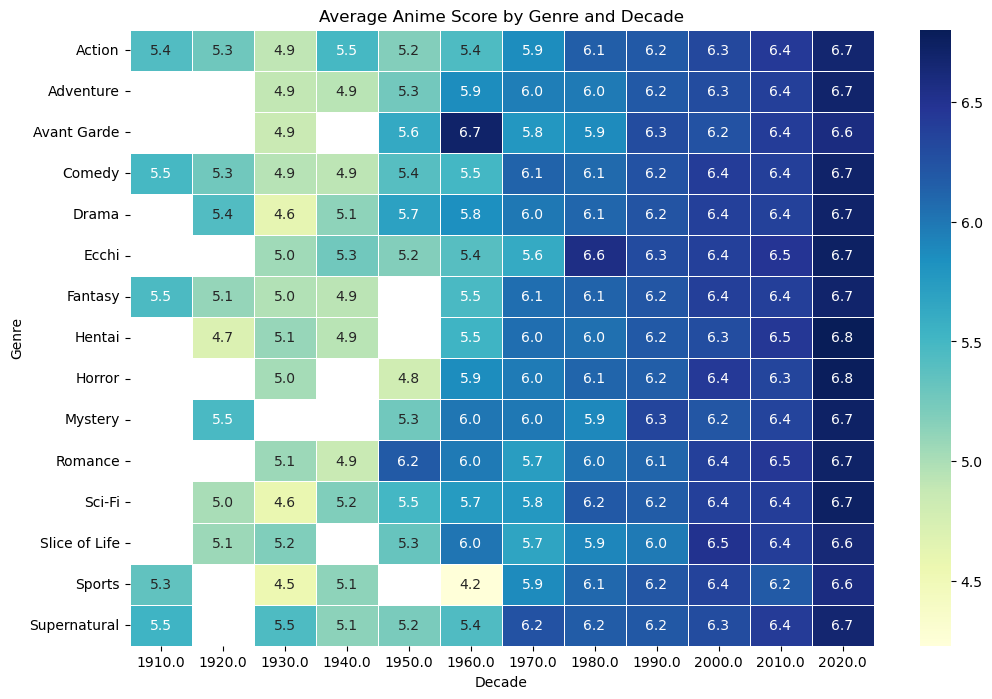

In [75]:
# Select top 15 genres by total frequency to keep the chart readable
top_genres = anime_genres['genres'].value_counts().head(15).index

# Filter the genre dataframe
genre_trend = anime_genres[anime_genres['genres'].isin(top_genres)]

# Create a 'decade' column for aggregation
genre_trend['decade'] = (genre_trend['start_year'] // 10) * 10

# Pivot table: Index=Genres, Columns=Decade, Values=Mean Score
heatmap_data = genre_trend.pivot_table(index='genres', columns='decade', values='score', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title("Average Anime Score by Genre and Decade")
plt.xlabel("Decade")
plt.ylabel("Genre")
plt.show()

In [76]:
# Drop rows where there is no primary studio
anime_studios = anime_clean[anime_clean['primary_studio'].notna()]

# Aggregation: Count productions and calculate mean score
studio_stats = anime_studios.groupby('primary_studio').agg(
    production_count=('mal_id', 'count'),
    avg_score=('score', 'mean'),
    total_favorites=('favorites', 'sum')
).reset_index()

# Filter: Only keep studios with > 20 productions to avoid noise
top_studios = studio_stats[studio_stats['production_count'] > 20]

# --- TREEMAP (Market Share) ---
fig_tree = px.treemap(
    top_studios,
    path=[px.Constant("All Studios"), 'primary_studio'],
    values='production_count',
    color='avg_score',
    color_continuous_scale='RdBu',  # Red = Bad, Blue = Good
    title='Studio Dominance: Box Size = Production Volume, Color = Average Score',
    hover_data=['avg_score']
)
fig_tree.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig_tree.show()

In [77]:
# --- SCATTER (Quality vs Quantity) ---
# This answers: "Who is the 'Prestige' studio?"

top_studios = top_studios.copy()

# pick top 20 by favorites (change column if you want)
top20_idx = top_studios.nlargest(20, "total_favorites").index

top_studios["label"] = ""
top_studios.loc[top20_idx, "label"] = top_studios.loc[top20_idx, "primary_studio"]

fig_scatter = px.scatter(
    top_studios,
    x="production_count",
    y="avg_score",
    size="total_favorites",
    text="label",
    title="Studio Strategy: Quality (Y) vs. Quantity (X)",
    labels={
        "production_count": "Total Anime Produced",
        "avg_score": "Average Score"
    },
    height=600
)

fig_scatter.update_traces(
    mode="markers+text",
    textposition="top center",
    textfont=dict(size=12)
)

fig_scatter.show()

### TRYING A NEW Graph: Global MAP

In [78]:
# Count users per country
country_counts = profiles_df['location'].value_counts().reset_index()
country_counts.columns = ['location', 'User_Count']

# convert to ISO-3 to avoid annoying warnings in plotly
codes = px.data.gapminder()[["country", "iso_alpha"]].drop_duplicates()

country_counts = country_counts.merge(
    codes, left_on="location", right_on="country", how="left"
)

fig = px.choropleth(
    country_counts,
    locations="iso_alpha",
    locationmode="ISO-3",
    color="User_Count",
    hover_name="location",
    color_continuous_scale=px.colors.diverging.Portland,
    title="User Distribution by Extracted Location"
)

fig.update_layout(
    margin=dict(l=0, r=0, t=40, b=0),
    geo=dict(
        projection_scale=1.1,  # zoom in slightly
        center=dict(lat=0, lon=0)
    ),
    width=1100,
    height=650
)

fig.show()

Separating japan won't make much difference in this graph.
We could chech wheter this map changes if we count the percentage of people watch anime compared to the whole population of the country

In [79]:
# 1. Count users per country (from your dataset)
country_counts = profiles_df['location'].value_counts().reset_index()
country_counts.columns = ['location', 'User_Count']

# 2. Get population + ISO-3 codes from gapminder
gap = px.data.gapminder()[['country', 'iso_alpha', 'year', 'pop']]

# take the latest year per country
gap_latest = gap.sort_values('year').drop_duplicates('country', keep='last')

# 3. Merge your counts with population data
country_counts = country_counts.merge(
    gap_latest,
    left_on='location',   # my country names
    right_on='country',   # gapminder country names
    how='left'
)

# 4. Compute users percentage
country_counts['users_percent'] = (country_counts['User_Count'] / country_counts['pop'] * 100)

# 5. Plot: anime users normalized by population
fig = px.choropleth(
    country_counts,
    locations="iso_alpha",
    locationmode='ISO-3',
    color="users_percent",
    hover_name="location",
    hover_data={
        "User_Count": True,
        "pop": True,
        "users_percent": ':.2f'
    },
    color_continuous_scale=px.colors.diverging.Portland,
    title='Anime Users per 100k Inhabitants by Country'
)

fig.update_layout(
    margin=dict(l=0, r=0, t=40, b=0),
    geo=dict(
        projection_scale=1.1,  # zoom in slightly
        center=dict(lat=0, lon=0)
    ),
    width=1100,
    height=650
)

fig.show()


This way we can tell Australia becomes much more interesting.
Though we could use a logarithmic scale in order to visualize better the differences between other countries too.
From the previous graph we couldn't tell exactly which were the countries the least percentage of users.
With the logarithmic scale we can tell India has the least amount of people (compared to its own population) watching anime, followed by China and then Indonesia and Brasil on the same level.

In [80]:
# 1. Count users per country (from your dataset)
country_counts = profiles_df['location'].value_counts().reset_index()
country_counts.columns = ['location', 'User_Count']

# 2. Get population + ISO-3 codes from gapminder
gap = px.data.gapminder()[['country', 'iso_alpha', 'year', 'pop']]

# take the latest year per country
gap_latest = gap.sort_values('year').drop_duplicates('country', keep='last')

# 3. Merge your counts with population data
country_counts = country_counts.merge(
    gap_latest,
    left_on='location',   # my country names
    right_on='country',   # gapminder country names
    how='left'
)

# 4. Compute users percentage
country_counts['users_percent'] = (
    country_counts['User_Count'] / country_counts['pop'] * 100
)

country_counts['users_percent_log'] = np.log10(country_counts['users_percent'].replace(0, np.nan))


# 5. Plot: anime users normalized by population
fig = px.choropleth(
    country_counts,
    locations="iso_alpha",
    locationmode='ISO-3',
    color="users_percent_log",
    hover_name="location",
    hover_data={
        "User_Count": True,
        "pop": True,
        "users_percent": ':.2f'
    },
    color_continuous_scale=px.colors.diverging.Portland,
    title='Anime Users per 100k Inhabitants by Country'
)

fig.update_layout(
    margin=dict(l=0, r=0, t=40, b=0),
    geo=dict(
        projection_scale=1.1,  # zoom in slightly
        center=dict(lat=0, lon=0)
    ),
    width=1100,
    height=650
)

fig.show()

## KEEP BOTH, but show your reasoning

In [81]:
#TODO 
-Could I use "Indicators" for our dataset?
    
-A sunburst on the same data of the map?

-A polarchart on something?

Object `dataset` not found.
Object `something` not found.


Init signature: map(self, /, *args, **kwargs)
Docstring:     
map(func, *iterables) --> map object

Make an iterator that computes the function using arguments from
each of the iterables.  Stops when the shortest iterable is exhausted.
Type:           type
Subclasses:     

In [82]:
import plotly.graph_objects as go

anime_df = pd.read_csv('datasets/details_cleaned.csv')

# Calcoliamo il valore medio del rating
avg_rating = anime_df['score'].mean()

fig = go.Figure(go.Indicator(
    mode = "gauge+number",
    value = avg_rating,
    title = {'text': "Average Anime Score"},
    gauge = {'axis': {'range': [0, 10]},
             'bar': {'color': "darkblue"},
             'steps': [
                 {'range': [0, 5], 'color': "red"},
                 {'range': [5, 7], 'color': "yellow"},
                 {'range': [7, 10], 'color': "green"}]}
))
fig.show()

## Let's see how international the voice acting database is.

In [83]:
fig = px.bar(
    lang_counts.head(10),
    x='role_count',
    y='language',
    orientation='h',
    title='Voice Acting Languages in Anime (Top 10 Including Japanese)',
    color='role_count',
    color_continuous_scale='Viridis'
)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()


NameError: name 'lang_counts' is not defined

### Now let's check without the japanese, or using a logarithmic scale

In [ ]:
fig = px.bar(
    lang_counts.head(10), 
    x='role_count',
    y='language',
    orientation='h',
    title='Voice Acting Languages (Log Scale)',
    color='role_count',
    color_continuous_scale='Viridis'
)

fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.update_xaxes(type='log')
fig.show()


In [ ]:
person_voice_works_df = pd.read_csv('datasets/person_voice_works_cleaned.csv')
# 1. Count distinct roles by language
lang_counts = person_voice_works_df['language'].value_counts().reset_index()
lang_counts.columns = ['language', 'role_count']

# 2. Separate Japanese (Dominant) from Others to make the chart readable
non_jp = lang_counts[lang_counts['language'] != 'Japanese']

# --- PLOT ---
fig = px.bar(
    non_jp.head(10), # Top 10 non-Japanese languages
    x='role_count',
    y='language',
    orientation='h',
    title='Globalization of Anime: Top Non-Japanese Voice Acting Languages',
    color='role_count',
    color_continuous_scale='Viridis'
)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

## The Gatekeepers (Licensors Market Share)
Anime reaches the global West through Licensors. Who owns the market? Technique: Pie Chart (with "Other" grouping).

In [ ]:
# 1. Explode Licensors (same as you already have)
anime_lic = anime_clean.assign(
    licensors=anime_clean['licensors'].apply(ast.literal_eval)
).explode('licensors')

# Remove Unknown / None
anime_lic = anime_lic[anime_lic['licensors'].notna()]

# 2. Count
licensor_counts = anime_lic['licensors'].value_counts().reset_index()
licensor_counts.columns = ['Licensor', 'Count']

# 3. PLOT ALL LICENSORS (no grouping)
fig = px.pie(
    licensor_counts,
    values='Count',
    names='Licensor',
    title='Market Share of All Anime Licensors',
    hole=0.4
)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()


This Pie Chart doesn't work because we have too many licensors, we could use a Treemap instead

In [ ]:
# Treemap of licensors
fig = px.treemap(
    licensor_counts,
    path=['Licensor'],
    values='Count',
    title='Anime Licensors – Market Share (Treemap)'
)

fig.update_traces(textinfo="label+percent entry")
fig.show()


In [ ]:
# Birthday extraction
profiles_df['birthday'] = pd.to_datetime(profiles_df['birthday'], errors='coerce')
profiles_df['bday_year'] = profiles_df['birthday'].dt.year

# Compute average score per user BUT only valid scores 1–10
valid_ratings = ratings_df[ratings_df['score'].between(1, 10)]

avg_user_score = (valid_ratings.groupby('username')['score'].mean().reset_index())

# Merge
user_history = pd.merge(profiles_df[['username', 'bday_year']],avg_user_score,on='username',how='inner')

# Group
cohort_analysis = (user_history.groupby('bday_year')['score'].agg(avg_score='mean', users='count').reset_index())
cohort_analysis = cohort_analysis[cohort_analysis['users'] >= 50]


# --- PLOT ---
fig = px.line(
    cohort_analysis,
    x='bday_year',
    y='avg_score',
    markers=True,
    title='Do Different Age Cohorts Rate Differently?',
    labels={'bday_year': 'Birth Year', 'avg_score': 'Average Score Given'}
)

fig_users = px.bar(
    cohort_analysis,
    x='bday_year',
    y='users',
    title='Users Per Birth Year Cohort'
)
fig_users.show()
fig.show()

Looking only at cohorts with enough users to be meaningful, we find that:

1985–1995 cohorts
Average ratings are fairly stable around ~7.6–7.7, suggesting consistent, balanced rating behavior.

Late 1990s → Early 2000s cohorts
There is a gradual decline toward ~7.4–7.5.
Possible explanation: these users rate more shows, including mid-tier titles, and MAL became mainstream in their era → broader viewing → slightly harsher averages.

Post-2008 cohorts
Scores jump upward again. This could reflect: fewer users, tendency to rate only popular modern titles or younger users being more enthusiastic.

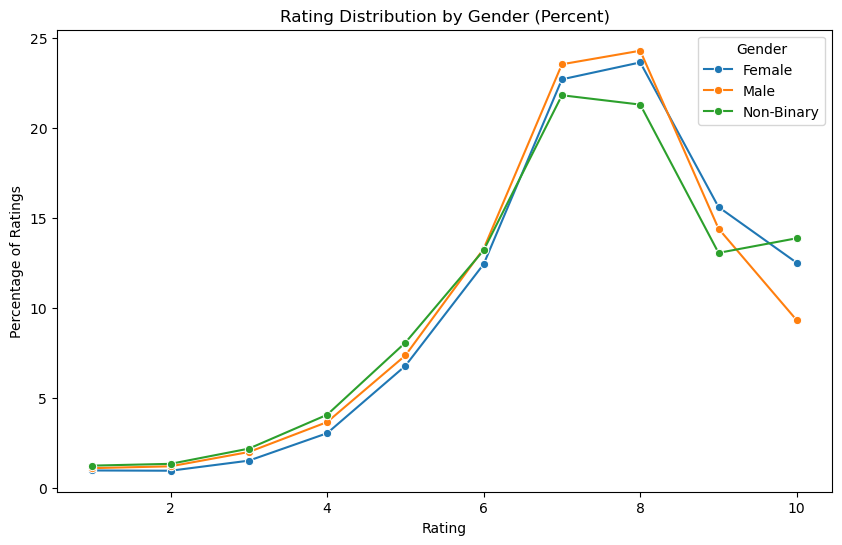

In [ ]:
counts = (
    merged_df
    .groupby(['gender','score'])
    .size()
    .reset_index(name='count')
)

# compute total ratings per gender
totals = counts.groupby('gender')['count'].transform('sum')

# create percent col
counts['percent'] = counts['count'] / totals * 100

rating_dist = counts

plt.figure(figsize=(10,6))
sns.lineplot(
    data=rating_dist,
    x='score',
    y='percent',
    hue='gender',
    marker='o'
)

plt.title('Rating Distribution by Gender (Percent)')
plt.xlabel('Rating')
plt.ylabel('Percentage of Ratings')
plt.legend(title='Gender')
plt.show()



We used to percentages instead of raw counts so we could compare how each gender actually rates, instead of just seeing which group has more people in it.
All genders rate pretty similarly overall, with most ratings clustered around 7 and 8. It looks like non-binary users show a bit more “spread”, giving both more low scores and more 10s compared to the others, while males and females look slightly more conservative around the middle.

These differences should be interpreted with caution, as gender groups are not equally represented in the dataset.

In [ ]:
# Aggregate: Count by Year and Type
format_counts = anime_clean.groupby(['start_year', 'type']).size().reset_index(name='count')
format_counts = format_counts[(format_counts['start_year'] >= 1960) & (format_counts['start_year'] <= 2025)]

# Calculate Percentage per Year (Vectorized)
# We merge the yearly totals back to calculate the share
yearly_totals = format_counts.groupby('start_year')['count'].transform('sum')
format_counts['share'] = format_counts['count'] / yearly_totals

# --- PLOT ---
fig = px.area(
    format_counts,
    x="start_year",
    y="share",
    color="type",
    title="The Format Wars: The Rise of TV and the Fall of the OVA (1960-2025)",
    labels={'share': 'Market Share', 'start_year': 'Year'},
)
fig.show()

The industry basically moved from “buy this on DVD/VHS” to “watch it online whenever you want.” OVAs were huge back when home video was the big thing, especially in the late 80s and 90s, but they slowly faded as discs stopped mattering. Meanwhile, ONAs exploded thanks to streaming platforms, YouTube, Netflix and so on, becoming one of the main ways anime gets released today. TV is still important and steady, but this chart really shows how technology changed where anime comes out and how people watch it.

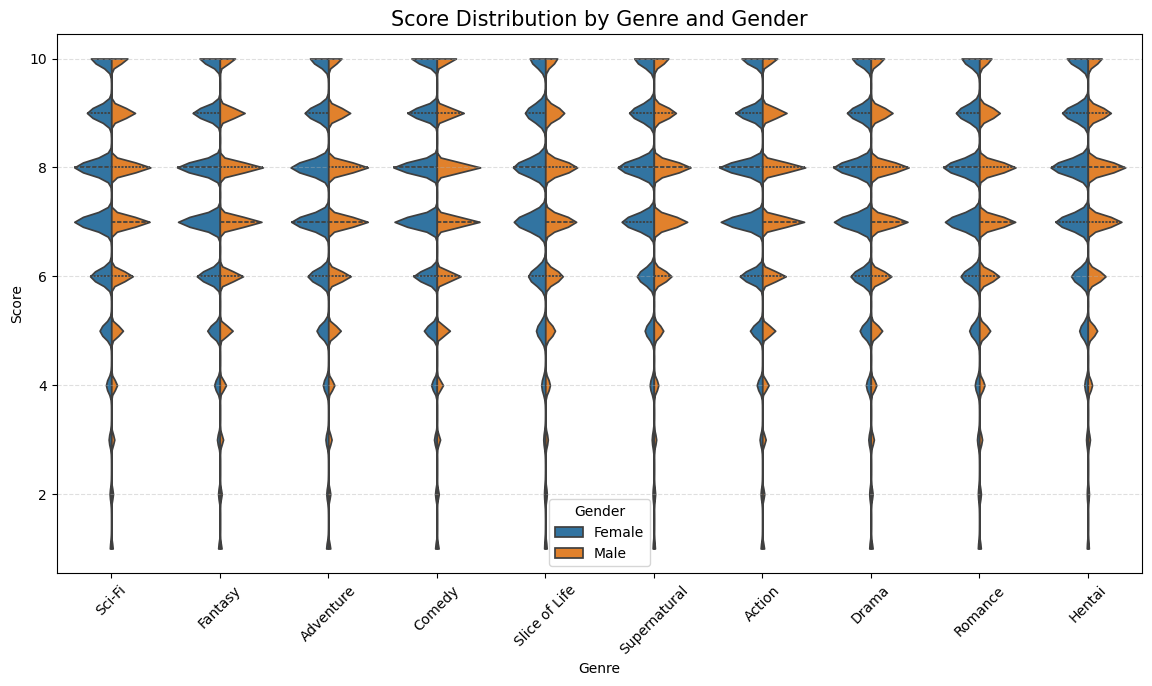

In [ ]:
# Filter profiles for gender (Male/Female only for binary comparison)
users = profiles_df[profiles_df['gender'].isin(['Male', 'Female'])][['username', 'gender']]

# Merge Ratings with Users (full dataset, scores > 0 only)
valid_ratings = ratings_df[ratings_df['score'] > 0]
user_ratings = pd.merge(valid_ratings, users, on='username', how='inner')

# Merge with Anime to get Genres
# We need to use the exploded 'anime_genres', but just the ID and Genre columns
anime_genre_map = anime_genres[['mal_id', 'genres', 'title']]
full_data = pd.merge(user_ratings, anime_genre_map, left_on='anime_id', right_on='mal_id', how='inner')

# Keep only those genres from the full rating data
full_data_top = full_data[full_data['genres'].isin(genre_order)]

# --- VIOLIN PLOT ---
plt.figure(figsize=(14, 7))
sns.violinplot(
    data=full_data_top,
    x='genres',
    y='score',
    hue='gender',
    order=genre_order,
    split=True,
    inner='quartile',
    cut=0
)
plt.xticks(rotation=45)
plt.title("Score Distribution by Genre and Gender", fontsize=15)
plt.xlabel("Genre")
plt.ylabel("Score")
plt.legend(title="Gender")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

#A violin plot was considered to explore score distributions by gender. However, 
# including all three gender categories made the visualization noisy and hard to interpret, 
# so we focused on Male vs Female comparison, as they represent the majority of the dataset. 
# Non-binary users were preserved in the dataset but excluded from this specific 
# visualization due to lower representation.”


From the violin plot we can see that male and female users rate anime in a very similar way. Most ratings for both genders stay between 6 and 9, and the shapes overlap a lot. This means gender doesn’t seem to strongly influence how people rate anime in general.

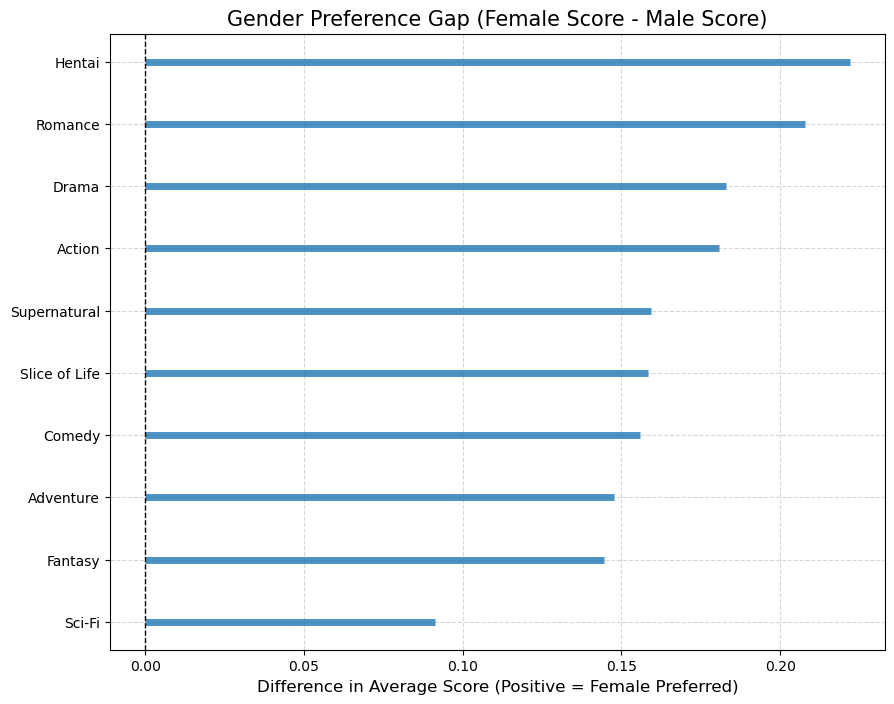

In [ ]:
#Using the same data we just computed, we could now visualize the gender preference gap.

# Aggregation: Mean score per Genre per Gender (unstack is used to pivot gender into columns: we would just have one "gender" column otherwise)
genre_gender_scores = full_data.groupby(['genres', 'gender'])['score'].mean().unstack()

# Calculate Gap and Filter for Top Genres
comparison = genre_gender_scores.loc[top_genres].copy()
comparison['diff'] = comparison['Female'] - comparison['Male']
comparison = comparison.sort_values('diff')

# Order genres by the same gap used above
genre_order = comparison.index.tolist()

# --- GAP PLOT  ---
plt.figure(figsize=(10, 8))
plt.hlines(
    y=comparison.index,
    xmin=0,
    xmax=comparison['diff'],
    color='C0',
    alpha=0.8,
    linewidth=5
)
plt.axvline(0, color='black', linestyle='--', linewidth=1) 
plt.title("Gender Preference Gap (Female Score - Male Score)", fontsize=15)
plt.xlabel("Difference in Average Score (Positive = Female Preferred)", fontsize=12)
plt.grid(linestyle='--', alpha=0.5)
plt.show()

When we zoom in on the difference in average scores, the gap plot shows that, on average, female users tend to rate slightly higher than male users across almost all genres. The difference is small but consistent, meaning women are usually just a bit more positive when giving scores compared to men.

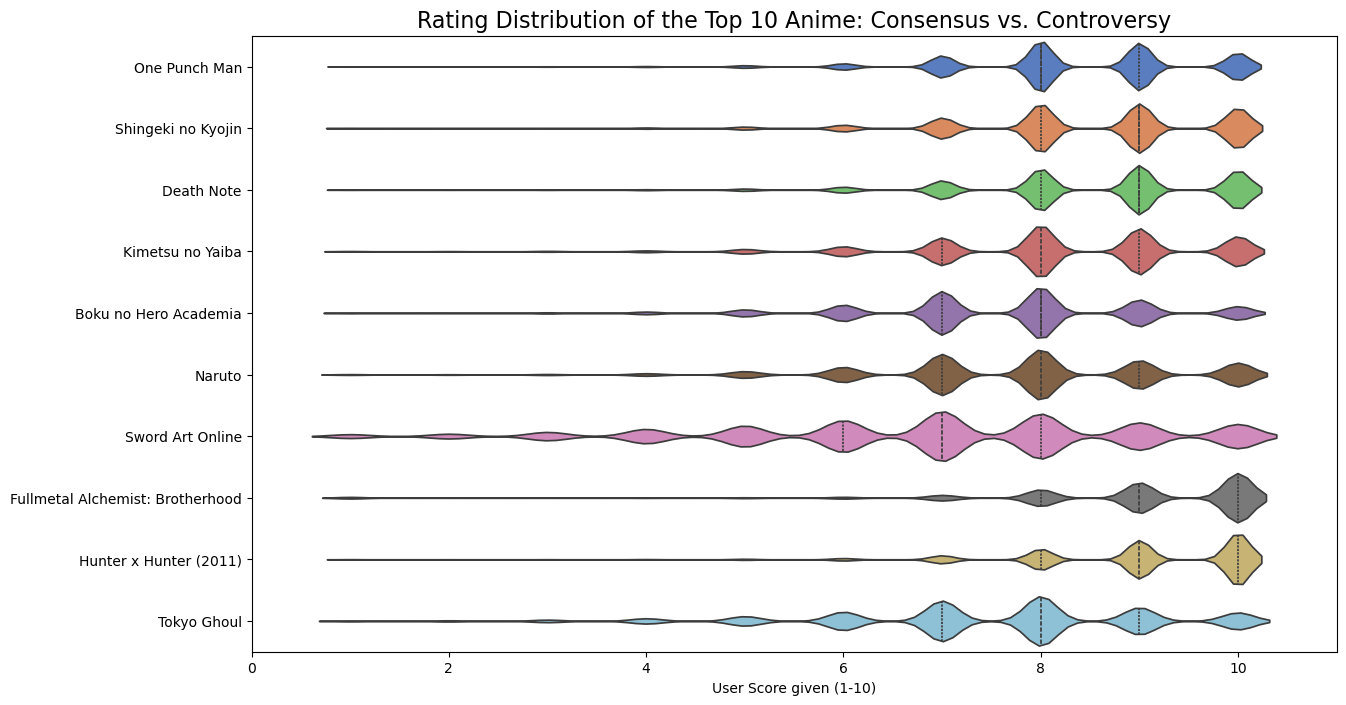

In [ ]:
# Identify the Top 10 Most Watched Anime
top_10_ids = anime_clean.nlargest(10, 'members')['mal_id']
top_10_titles = anime_clean.set_index('mal_id').loc[top_10_ids, 'title']

# Filter ratings_df
# Ideally, you do this merge carefully.
top_ratings = ratings_df[ratings_df['anime_id'].isin(top_10_ids)].copy()

# Add Titles for the plot
top_ratings['anime_title'] = top_ratings['anime_id'].map(top_10_titles)

# Filter out ratings with a score of 0
top_ratings = top_ratings[top_ratings['score'] != 0]

# --- PLOT ---
plt.figure(figsize=(14, 8))
sns.violinplot(
    data=top_ratings,
    x='score',
    y='anime_title',
    density_norm='width',
    hue="anime_title",
    palette='muted',
    inner='quartile' # Show the median and quartiles inside
)

plt.title("Rating Distribution of the Top 10 Anime", fontsize=16)
plt.xlabel("User Score given (1-10)")
plt.ylabel("")
plt.xlim(0, 11) # Scores are 1-10
plt.show()

Some top anime are “universally loved” with ratings clustered around 9–10 (like Fullmetal Alchemist: Brotherhood, Hunter x Hunter, Shingeki no Kyojin), while others are far more divisive, showing wide spreads across all scores (like Sword Art Online, Tokyo Ghoul, and Naruto).

Anime has 4 main target demographics: Shounen (Boys), Shojo (Girls), Seinen (Adult Men), Josei (Adult Women). Which one actually produces the highest-rated content?

In [ ]:
# Explode demographics
anime_demographics = anime_clean.assign(demographics=anime_clean["demographics"].apply(ast.literal_eval).explode("demographics"))

# Drop missing demographics
anime_demographics = anime_demographics[anime_demographics["demographics"].notna()]

# Plot
fig = px.box(
    anime_demographics,
    x="demographics",
    y="score",
    color="demographics",
    title="Target Audience vs. Critical Acclaim",
    points="suspectedoutliers",
    category_orders={"demographics": ["Kids", "Shounen", "Shoujo", "Seinen", "Josei"]}
    )

fig.update_xaxes(title_text="Demographics (ordered by target age)")
fig.update_yaxes(title_text="Score")

fig.show()



Scores don’t change dramatically across demographics, but Kids anime clearly performs worse, while Seinen shows the largest variability with both more masterpieces and more flops.

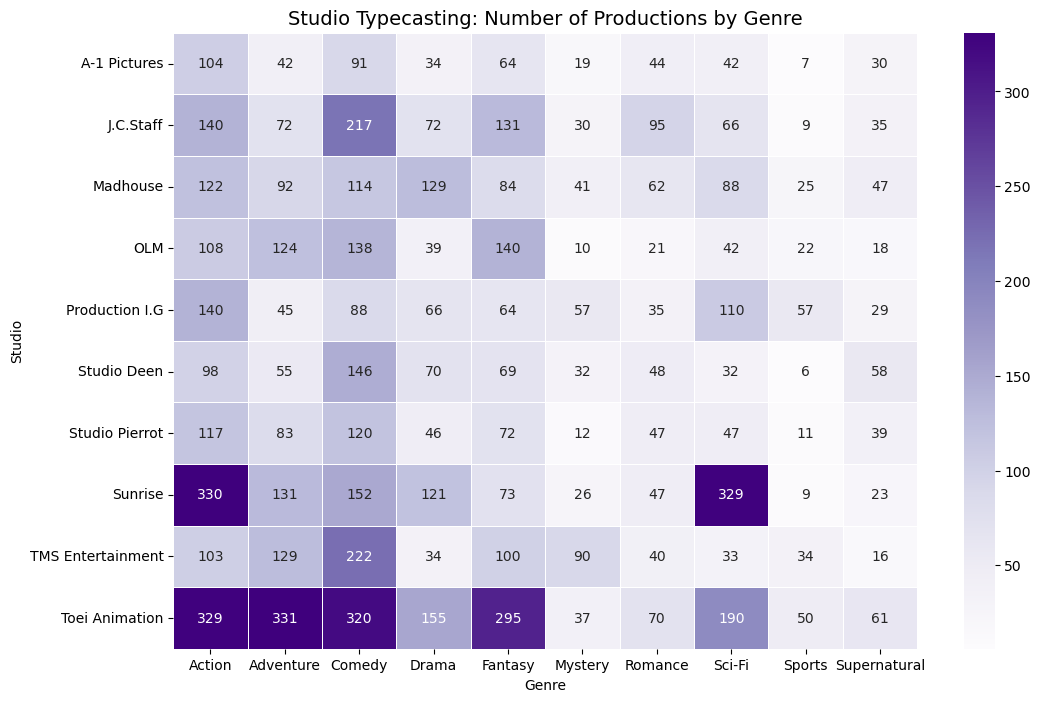

In [ ]:
# Top 10 studios
top_studios = anime_genres["primary_studio"].value_counts().head(10).index

# Filter only those studios
specialization_data = anime_genres[anime_genres["primary_studio"].isin(top_studios)]

# Top 10 genres (to keep readable)
specialization_data = specialization_data[specialization_data["genres"].isin(specialization_data["genres"].value_counts().head(10).index)]


# Pivot table (needed for the heatmap)
studio_genre_pivot = pd.crosstab(specialization_data["primary_studio"],specialization_data["genres"])

# --- HEATMAP ---
plt.figure(figsize=(12, 8))
sns.heatmap(
    studio_genre_pivot,
    annot=True,
    fmt="d",
    cmap="Purples",
    linewidths=.5
)

plt.title("Studio Typecasting: Number of Productions by Genre", fontsize=14)
plt.ylabel("Studio")
plt.xlabel("Genre")
plt.show()


The heatmap shows that studios aren’t all doing the same thing—most of them have clear comfort zones. Toei lives in Action/Adventure, Sunrise is basically a Sci-Fi machine, and J.C. Staff + TMS carry Comedy. Meanwhile Madhouse spreads across everything, but still leans toward Drama/Fantasy. In short: the anime industry is full of ‘specialist studios’ instead of generalists.